In [1]:
import numpy as np
import pandas as pd

In [26]:
taux_inflation = 1 + 5/100
taux_revalorisation_bareme = taux_inflation

In [27]:
taux = np.array([0, 0.1, 0.2, 0.5, 0.75])
seuils_tranches_initiales = np.array([0, 20000, 30000, 40000, 50000, np.inf])

def impot(revenu, seuils_tranches, taux):
    assert len(seuils_tranches) == len(taux) + 1
    return np.sum(np.diff(np.minimum(np.array([revenu]), seuils_tranches))  * taux)

In [28]:
def calcule_vecteur_inflateur(nombre_annees, taux):
    return  np.cumprod([1] + [taux for _ in range(nombre_annees - 1)])

In [29]:
nombre_annees = 100
annees = range(nombre_annees)

inflateur_prix = calcule_vecteur_inflateur(nombre_annees, taux_inflation)
inflateur_baremes = calcule_vecteur_inflateur(nombre_annees, taux_revalorisation_bareme)

seuils_par_annee = {
    annee: seuils_tranches_initiales * inflateur_baremes[annee]
    for annee in annees
    }

def meta_impot(impot, seuils_par_annee, taux, annee):
    seuils = seuils_par_annee[annee]
    impot_annee = lambda revenu: impot(revenu, seuils, taux)
    return impot_annee

impots_par_annee = {
    annee: meta_impot(impot, seuils_par_annee, taux, annee)
    for annee in annees
    }

In [30]:
revenus_euros_constants = np.concatenate([20*[0], np.linspace(40000, 60000, 50), (nombre_annees - 50 - 20)* [0]])
revenus_euros_courants = revenus_euros_constants * inflateur_prix
revenus_passes = np.concatenate([[0], revenus_euros_courants[:-1]])

In [33]:
def calcul_impots(impots_par_annee, revenu):
    ensemble_des_impots = [
        impots_par_annee[annee](revenu[annee])
        for annee in set(impots_par_annee)
        ]
    return ensemble_des_impots

In [34]:
impots_n = calcul_impots(impots_par_annee, revenus_euros_courants) / inflateur_prix
impots_lag_n = calcul_impots(impots_par_annee, revenus_passes) / inflateur_prix

sum(impots_n) - sum(impots_lag_n)

19047.619047619082

In [35]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
df = pd.DataFrame({
    "annee": annees,
    "impots_n": impots_n,
    "impots_lag_n": impots_lag_n
    })

R[write to console]: Learn more about the underlying theory at https://ggplot2-book.org/



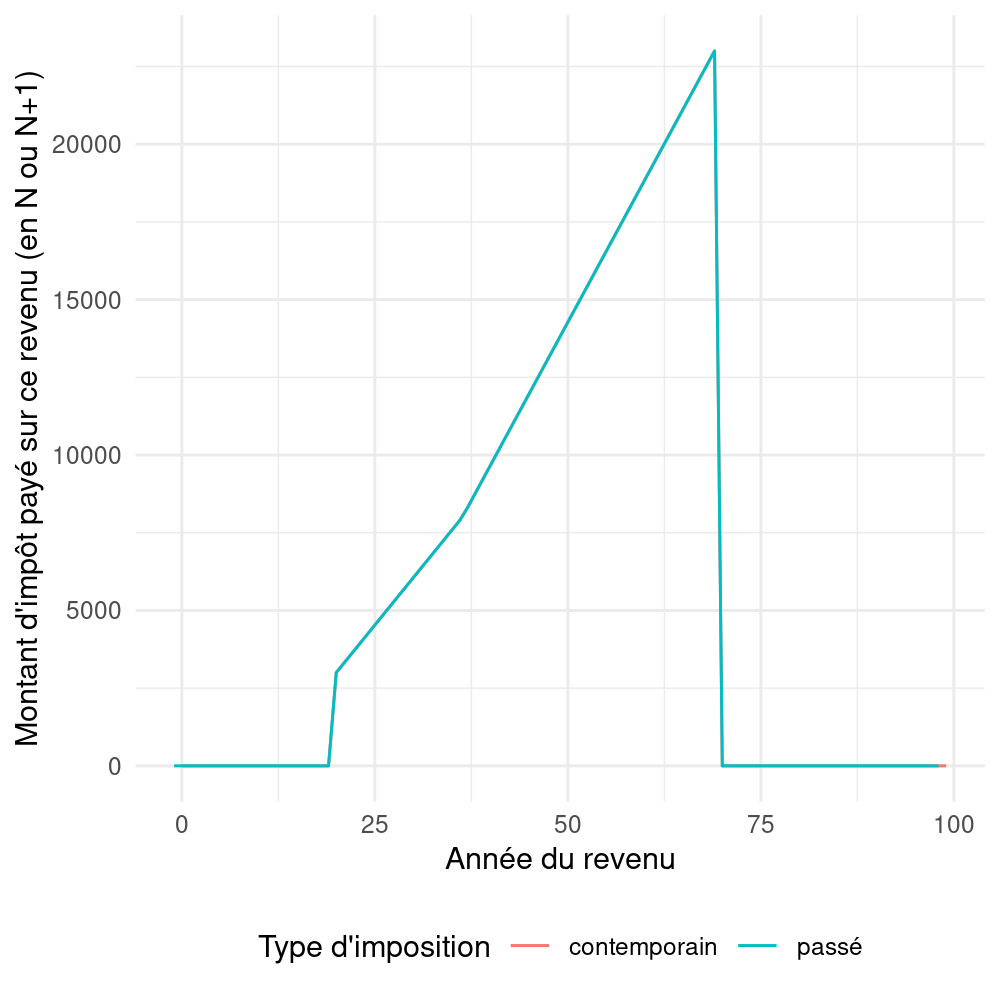

In [11]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

library(ggplot2)
library(plyr)
library(tidyr)

df <- (
    df
    %>% pivot_longer(
        cols = c("impots_n", "impots_lag_n"),
        names_to = "type_impot",
        values_to = "montant"
        )
    %>% mutate(
        type_impot = mapvalues(type_impot, from = c("impots_n", "impots_lag_n"), to = c("contemporain", "passé")),
        annee_revenu = ifelse(type_impot == "contemporain", annee, annee - 1)
        )
    )

(
    ggplot(df)
    + aes(
        x = annee_revenu,
        y = montant,
        color = type_impot
        )
    + geom_line()
    + theme_minimal()
    + theme(legend.position = "bottom")
    + labs(
        x = "Année du revenu",
        y = "Montant d'impôt payé sur ce revenu (en N ou N+1)",
        color = "Type d'imposition"
        )
)

In [12]:
def simulation(taux_inflation, taux_bareme):
    nombre_annees = 100
    annees = range(nombre_annees)

    inflateur_prix = calcule_vecteur_inflateur(nombre_annees, taux_inflation)
    inflateur_baremes = calcule_vecteur_inflateur(nombre_annees, taux_revalorisation_bareme)

    seuils_par_annee = {
        annee: seuils_tranches_initiales * inflateur_baremes[annee]
        for annee in annees
        }

    impots_par_annee = {
        annee: meta_impot(impot, seuils_par_annee, taux, annee)
        for annee in annees
        }
    
    revenus_euros_constants = np.concatenate([20*[0], np.linspace(40000, 70000, 50), (nombre_annees - 50 - 20)* [0]])
    revenus_euros_courants = revenus_euros_constants * inflateur_prix
    revenus_passes = np.concatenate([[0], revenus_euros_courants[:-1]])
    
    impots_n = calcul_impots(impots_par_annee, revenus_euros_courants) / inflateur_prix
    impots_lag_n = calcul_impots(impots_par_annee, revenus_passes) / inflateur_prix
    
    return sum(impots_n) - sum(impots_lag_n)

In [20]:
taux_inflation_simules = np.linspace(1, 1.5, 100)
taux_bareme_simules =  np.linspace(1, 1.5, 100)

resultats = [
    (taux_inflation, taux_bareme, simulation(taux_inflation, taux_bareme))
    for taux_inflation in taux_inflation_simules
    for taux_bareme in taux_bareme_simules
    ]

df = pd.DataFrame(resultats, columns = ["inflation", "revalorisation_bareme", "difference"])

df['difference'] = df['difference'] / df['difference'].max()

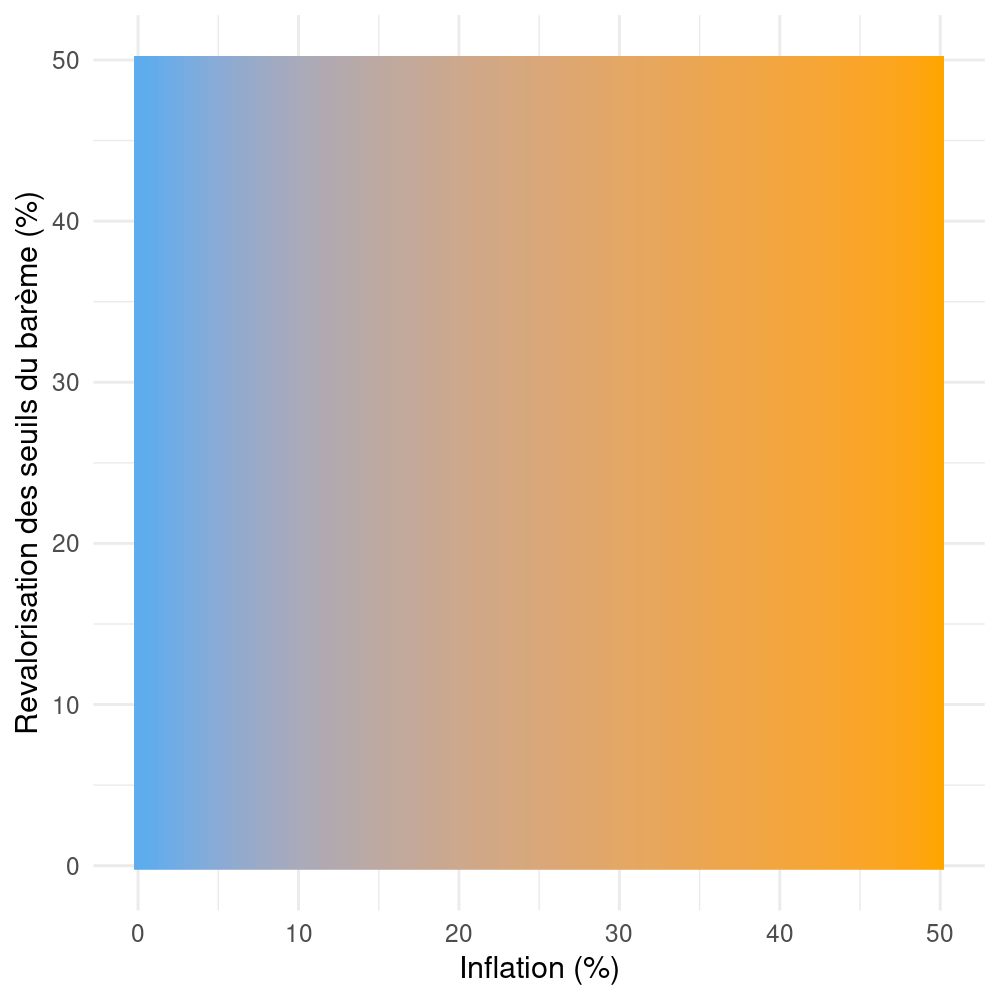

In [21]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

(
    ggplot(df)
    + aes(
        x = 100 * (inflation - 1),
        y = 100 * (revalorisation_bareme - 1),
        fill = difference
        )
    + geom_raster()
    + theme_minimal()
    + scale_fill_continuous(low = "steelblue2", high = "orange")
    + theme(legend.position = "none")
    + labs(
        x = "Inflation (%)",
        y = "Revalorisation des seuils du barème (%)",
        color = "Différence de montant d'imposition entre les deux systèmes"
        )
)